# Spike Computational Neuroscience Community

<div style="font-family: Arial, sans-serif; margin: 20px;">
    <h1 style="text-align: center; color: #333;">EEG Processing: An Entry to the World of Brain Waves</h1>
    <h2 style="text-align: center; color: #555;">Session 7: Basics of machine learning and Scikit-learn</h2>
    <p style="text-align: center; color: #666; font-size: 16px;">
        Author: Mohammadreza Shahsavari<br>
        Contact: <a href="mailto:mohamadrezashahsavary@gmail.com" style="color: #0066cc; text-decoration: none;">mohamadrezashahsavary@gmail.com</a>
    </p>
</div>







## What is Classification?
### Imagine We're Sorting Objects into Boxes

Let's say we have two types of objects: **blue circles** and **green triangles**. These objects are scattered on a table, and we want to separate them into two different boxes: one for circles and one for triangles.

But instead of physically picking them up, we're using a machine that can see where each object is on the table (like their position on a graph) and then decides which box (or class) they belong to.

### The Decision Line (Boundary)

In the image you provided, there's a black line on the graph. This line is like a divider on the table that separates the circles from the triangles.

- **Everything on one side of the line goes into the "Circle" box.**
- **Everything on the other side goes into the "Triangle" box.**

### How Does the Machine Know Where to Draw the Line?

The machine (which in this case is a **Support Vector Machine**, or SVM) looks at the positions of all the objects (circles and triangles) and tries to find the best place to draw the line so that:

- All the circles are on one side of the line.
- All the triangles are on the other side.

The machine wants to make sure that the line is placed in a way that it can confidently separate the circles and triangles, even if we add new objects later. It tries to find the line that leaves the biggest gap (or margin) between the closest circle and triangle.

### What Happens When We Add a New Object?

Imagine we find a new object and we don’t know if it’s a circle or a triangle yet. We place it on the table, and the machine looks at which side of the line it falls on:

- If it’s on the circle side, the machine will say, “This must be a circle!” and put it in the circle box.
- If it’s on the triangle side, the machine will say, “This must be a triangle!” and put it in the triangle box.

### In Summary

Classification is like teaching a machine to draw a line (or boundary) on a graph so it can separate and identify different types of objects. Once it learns this, it can sort new objects into the correct categories based on which side of the line they fall on.


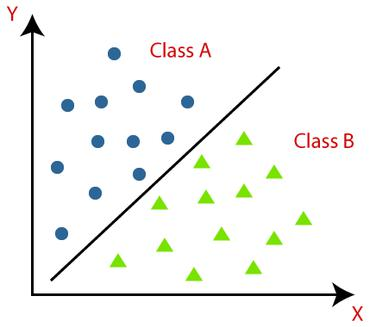

# Let's classify Parkinson's disease
Here, we aim to perform a binary (2-class) classification to distinguish Parkinson's patients from healthy controls using EEG band power features.

## Downalod and Extract the Dataset

In [ ]:
# Dowloading the EDF data
import gdown
import os
import zipfile

eeg_arch_url = 'https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD'

eeg_arch_file_name = 'EEGs.zip'  # Assuming the file is now a ZIP file

gdown.download(eeg_arch_url, eeg_arch_file_name, quiet=False)

eeg_arch_path = os.path.join('/content', eeg_arch_file_name)

# Unzip the file
with zipfile.ZipFile(eeg_arch_path, 'r') as zip_ref:
    zip_ref.extractall()

!ls -l /content

Downloading...
From (original): https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD
From (redirected): https://drive.google.com/uc?id=1rynIhpIAQc4OzX4nCrrnxOXMsdLt7xWD&confirm=t&uuid=52f16206-163a-4da2-bb6c-1bc6c8235451
To: /content/EEGs.zip
100%|██████████| 162M/162M [00:01<00:00, 88.4MB/s]


total 157820
-rw-r--r-- 1 root root 161595831 Aug 24 15:26  EEGs.zip
drwxr-xr-x 4 root root      4096 Aug 24 13:59 'Preprocessed Uc San Diego Dataset'
drwxr-xr-x 1 root root      4096 Aug 22 13:24  sample_data


##Step 1: Load EEG Signals from .mat Files

In this step, we load the EEG signals from the .mat files stored in the "PD" (Parkinson's Disease) and "HC" (Healthy Control) folders. We use the scipy.io module to load each .mat file, extract the EEG data, and store them in lists for further processing.

In [ ]:
import os
from scipy.io import loadmat
import numpy as np

# Define the paths
base_path = "/content/Preprocessed Uc San Diego Dataset"
pd_path = os.path.join(base_path, "PD")
hc_path = os.path.join(base_path, "HC")

# Get list of files
pd_files = [os.path.join(pd_path, f) for f in os.listdir(pd_path) if f.endswith('.mat')]
hc_files = [os.path.join(hc_path, f) for f in os.listdir(hc_path) if f.endswith('.mat')]

# Function to load .mat files
def load_mat_file(filepath):
    mat = loadmat(filepath)
    # Assuming EEG data is stored under a specific key, e.g., 'data'
    # Modify this depending on the actual structure of your .mat files
    return mat['time'][:32, :]

# Load all EEG signals
pd_signals = [load_mat_file(f) for f in pd_files]
hc_signals = [load_mat_file(f) for f in hc_files]



## Step 2: Calculate Power Bands

In this step, we calculate the power in specific frequency bands (like delta, theta, alpha, beta, gamma) from each EEG signal. These calculated power values act as features that we will use to train our SVM classifier.

### Why Do We Need to Extract Features?

Traditional machine learning models like SVM are not designed to handle complex, raw data like EEG signals directly. Unlike deep learning models, which can automatically learn patterns from raw data, SVMs need simpler, more structured inputs to work effectively. Here’s why feature extraction is important:

- **Simplifies the Data:** Raw EEG signals are very complex and contain a lot of noise. SVMs can't easily make sense of this complexity. By extracting features (like power in specific frequency bands), we turn the raw data into simpler, more meaningful information that the SVM can process.

- **Improves Model Accuracy:** Extracting relevant features helps the SVM focus on the most important aspects of the data, which leads to better performance and more accurate classifications.

- **Makes the Model More Efficient:** Handling raw data would be too much for an SVM, leading to slow and inefficient training. Feature extraction reduces the amount of data the SVM has to process, making it faster and more effective.

In simple terms, because traditional models like SVM aren't built to handle the raw complexity of EEG data, we extract features to make the data easier for them to understand and work with. This step is crucial for getting good results with an SVM.


In [ ]:
from scipy.signal import welch

# Define frequency bands
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def calculate_power_bands(signal, fs=256):  # Assuming a sampling frequency (fs) of 128 Hz
    power_bands = {}
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        power_bands[band] = np.trapz(psd[idx_band], freqs[idx_band])
    return power_bands

# Calculate power bands for each signal and each channel
def extract_features(signals):
    features = []
    for signal in signals:
        # Assuming signal shape is (channels, samples)
        signal_features = []
        for channel in signal:
            power_band = calculate_power_bands(channel)
            signal_features.extend(power_band.values())
        features.append(signal_features)
    return np.array(features)

pd_features = extract_features(pd_signals)
hc_features = extract_features(hc_signals)


In [ ]:
print(hc_features.shape)

(500, 160)


##Step 3: Prepare Labels and Combine Data

In this part, we prepare labels for the features extracted from the EEG signals. The features from the "PD" folder are labeled as 1 (Parkinson's Disease), and those from the "HC" folder are labeled as 0 (Healthy Control). We then combine these features and labels into a single dataset for training and testing.

In [ ]:
# Labels
pd_labels = np.ones(len(pd_features))
hc_labels = np.zeros(len(hc_features))

# Combine the data and labels
X = np.vstack((pd_features, hc_features))
y = np.hstack((pd_labels, hc_labels))


In [ ]:
i = 54

print("features: ", X[i, :], 'belong to class:', y[i])



features:  [0.12877343 0.11310185 0.01850307 0.03100546 0.02033406 0.0858336
 0.07255566 0.01575231 0.02999503 0.02061899 0.18710858 0.13568302
 0.01173343 0.06099903 0.06399526 0.06509882 0.03559817 0.01275917
 0.02984479 0.0211282  0.03718942 0.02279313 0.00686987 0.01940718
 0.0146176  0.04472819 0.03785375 0.01412185 0.0644625  0.08978252
 0.0435159  0.02840412 0.0188116  0.16540653 0.32670777 0.01718987
 0.01199288 0.01112209 0.02497834 0.02466415 0.02014805 0.01022219
 0.01141189 0.0143056  0.00839541 0.01361129 0.01608188 0.01822327
 0.04060291 0.04405831 0.05191469 0.04781728 0.06545422 0.15825108
 0.13382745 0.02584624 0.02429222 0.0332953  0.02560788 0.01630299
 0.03571706 0.0384023  0.01941488 0.02171601 0.00816307 0.03799404
 0.06220225 0.04810773 0.0433839  0.02187389 0.03788931 0.10252756
 0.08797607 0.07520056 0.05498366 0.06563617 0.1207296  0.07450217
 0.07754469 0.05166827 0.06803429 0.09932916 0.04886026 0.06881078
 0.04283546 0.05161684 0.10990641 0.03938818 0.03865

##Step 4: Train SVM Classifier

We train an SVM classifier using the extracted features. The dataset is split into training and testing sets, and the SVM is trained on the training data. We then predict the labels for the test set and evaluate the classifier's performance using accuracy and a detailed classification report.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

##Step 5: Evaluate the Classifier

Finally, we evaluate the classifier's performance using metrics like accuracy, precision, recall, and F1-score, which are provided in the classification report. This evaluation helps us understand how well our model is performing in distinguishing between Parkinson's Disease and Healthy Control based on the EEG signals.

In [ ]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       104
         1.0       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
def predict(signal):
  return 0